# **가설 검정**

## Member와 transaction data를 join해서 분석하기

 * member에는 city, bd (설명에 따르면, age와 같은 변수), gnedeer, registered_via, registration_init_time이 존재함
 * 이들 자료형에 맞도록 EDA를 진행

In [1]:
# 데이터 다루는 가장 기본적인 library
import pandas as pd
import numpy as np
import os, pickle

from bokeh.io import show, output_file, output_notebook
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, LinearColorMapper, BasicTicker, PrintfTickFormatter, ColorBar
from bokeh.palettes import Spectral5, Oranges9, Viridis256, grey, inferno
from bokeh.plotting import figure
from bokeh.sampledata.autompg import autompg as df
from bokeh.transform import factor_cmap
import seaborn as sns
from matplotlib import pyplot as plt
output_notebook()

Loading BokehJS ...

In [2]:
answer = pickle.load(open('../tut_data/answer.pkl', 'rb'))
member = pickle.load(open('../tut_data/member.pkl', 'rb'))
transaction_summary = pickle.load(open('../tut_data/transaction_summary.pkl', 'rb'))
transaction_summary = transaction_summary.reset_index()
log_summary = pickle.load(open('../tut_data/log_summary.pkl', 'rb'))

In [3]:
import sys
print('answer size = %.2f GB'%(sys.getsizeof(answer)/1024/1024/1024))
print('member size = %.2f GB'%(sys.getsizeof(member)/1024/1024/1024))
print('transaction_summary size = %.2f GB'%(sys.getsizeof(transaction_summary)/1024/1024/1024))
print('log_summary size = %.2f GB'%(sys.getsizeof(log_summary)/1024/1024/1024))


answer size = 0.10 GB
member size = 1.11 GB
transaction_summary size = 0.63 GB
log_summary size = 0.80 GB


In [4]:
print('answer size = {}'.format(answer.shape))
print('member size = {}'.format(member.shape))
print('transaction_summary size = {}'.format(transaction_summary.shape))
print('log_summary size = {}'.format(log_summary.shape))

answer size = (992931, 2)
member size = (6769473, 6)
transaction_summary size = (2363626, 24)
log_summary size = (5226369, 9)


## Merge dataset

In [5]:
dat_1 = pd.merge(answer, member, how = 'left', on = 'msno')

In [6]:
dat_1 = pd.merge(dat_1, log_summary, how = 'left', on = 'msno')

In [7]:
data = pd.merge(dat_1, transaction_summary, how = 'left', on = 'msno')

In [8]:
data.groupby(['is_churn']).count()[['msno']].rename({'msno':'count'}).reset_index()

,is_churn,msno
0,0,929460
1,1,63471


$\Rightarrow$ 총 37개 column이 존재

|is_churn	| msno|
|:--:|:--:|
|0|929460|
|1|63471|

In [9]:
print('T/F ratio = %.2f %%'%(np.round(63471 / (929460 + 63471) * 100, 2)))

T/F ratio = 6.39 %


#### 만약 중복이 있다면 제거

In [10]:
data.drop_duplicates(inplace = True)

In [11]:
data.shape

(992931, 38)

In [12]:
data.columns

Index(['msno', 'is_churn', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'date_count', 'num_25_sum', 'num_50_sum',
       'num_75_sum', 'num_985_sum', 'num_100_sum', 'num_unq_sum',
       'total_secs_sum', 'index', 'plan_list_price_count',
       'plan_list_price_nunique', 'plan_list_price_entropy',
       'payment_method_id_nunique', 'payment_method_id_entropy',
       'actual_amount_paid_mean', 'actual_amount_paid_count',
       'actual_amount_paid_nunique', 'actual_amount_paid_entropy',
       'is_auto_renew_count', 'is_auto_renew_nunique',
       'transaction_date_first', 'transaction_date_last',
       'transaction_date_nunique', 'membership_expire_date_first',
       'membership_expire_date_last', 'membership_expire_date_nunique',
       'is_cancel_nunique', 'transaction_cycle_delta_mean',
       'transaction_cycle_delta_std', 'transaction_cycle_delta_min',
       'transaction_cycle_delta_max'],
      dtype='object')

In [13]:
# member는 115,770건
np.sum(np.isnan(data['city']))

# transaction으로부터 얻은 데이터는 모두 있음
np.sum(np.isnan(data['plan_list_price_nunique']))

# log 정보는 missing이 124,062만건
np.sum(np.isnan(data['num_100_sum']))

123062

### Missing이 sysmetic한가?

#### member의 missing

In [14]:
# 전체 missing
data[np.isnan(data['city'])].count()['msno']

115770

In [15]:
#https://stackoverflow.com/questions/15315452/selecting-with-complex-criteria-from-pandas-dataframe
a = data[np.isnan(data['city']) & (data['is_churn'] == 0)].shape[0]
b = data[np.isnan(data['city']) & (data['is_churn'] == 1)].shape[0]
b/(a + b)

0.05023753994990066

#### log의 missing

In [16]:
a = data[np.isnan(data['num_100_sum']) & (data['is_churn'] == 0)].shape[0]
b = data[np.isnan(data['num_100_sum']) & (data['is_churn'] == 1)].shape[0]
b/(a + b)

0.05133184898668964

$\Rightarrow$ 전체 level에서는 missing이 random하다고 보임

## **Churn ratio by Categorical variables**

In [17]:
### churn ratio by variable: 번거로운 작업을 줄이기 위해서 함수로 만들기
# https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-certain-columns-is-nan

def ratio_by_group(var):
    _data = data[data[var].notnull()]
    grp = _data.groupby(['is_churn', var]).agg({'is_churn': 'count'})
    # ratio
    res = grp.groupby(level=[var]).apply(lambda x: 100 * x / float(x.sum()))
    res.rename(index = str, columns = {'is_churn':'ratio'}, inplace = True)
    res = res.reset_index()[res.reset_index()['is_churn'] == '1']
    # total count
    cnt_data = _data.groupby([var]).count()['msno'].reset_index().rename(columns = {'msno': 'count'})
    cnt_data[var] = cnt_data[var].astype('str')
    res[var] = res[var].astype('str')
    # yes count
    grp_y = data[data['is_churn'] == 1].groupby(['is_churn', var]).agg({'is_churn': 'count'})
    grp_y = grp_y.rename(columns = {'is_churn':'count'}).reset_index()
    grp_y[var] = grp_y[var].astype('str')

    res = pd.merge(res, grp_y[[var, 'count']], how = 'left', on =var).rename(columns = {'count':'churn'})
    res = pd.merge(res, cnt_data, how = 'left', on =var).rename(columns = {'count':'total'})
    
    return res

def hist(data, var, width):
    p = figure(plot_width = width, x_range = data[var] \
             , title = 'User by ' + var, x_axis_label = var, y_axis_label = 'ratio')
    source = ColumnDataSource(data)
    colors = inferno(32)
    mapper = LinearColorMapper(palette= colors, low = 0, high = np.sum(data.total))
    p.vbar(x = var, top = 'ratio', width=1, source=source, fill_color={'field': 'total', 'transform': mapper})

    p.y_range.start = 0
    p.xgrid.grid_line_color = None
    p.xaxis.axis_label = var
    p.xaxis.major_label_orientation = 1.2

    color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="5pt",
                         ticker=BasicTicker(desired_num_ticks=len(colors)),
                         formatter=PrintfTickFormatter(format="%d"),
                         label_standoff=6, border_line_color=None, location=(0, 0))
    p.add_layout(color_bar, 'right')
    return p

## 성별 이탈율

In [18]:
dd = ratio_by_group('gender')
print(dd)
p = hist(dd, 'gender', 600)
show(p)

  is_churn  gender     ratio  churn   total
0        1  female  8.636628  16013  185408
1        1    male  8.844603  18245  206284


## 연령별

In [19]:
dd = ratio_by_group('bd')
print(dd)
p = hist(dd, 'bd', 800)
show(p)

    is_churn      bd       ratio  churn   total
0          1   -48.0   14.285714      1       7
1          1   -43.0   25.000000      1       4
2          1     0.0    4.754989  23180  487488
3          1     1.0    4.000000      1      25
4          1     2.0   20.000000      2      10
5          1     3.0   10.000000      1      10
6          1     4.0   10.000000      1      10
7          1     6.0   17.647059      3      17
8          1     7.0   20.000000      3      15
9          1    11.0   40.000000      4      10
10         1    12.0    8.000000      2      25
11         1    13.0   13.725490      7      51
12         1    14.0   21.794872     51     234
13         1    15.0   21.914358    174     794
14         1    16.0   20.369610    496    2435
15         1    17.0   19.446922   1090    5605
16         1    18.0   18.735038   1487    7937
17         1    19.0   16.817097   1621    9639
18         1    20.0   15.815014   2151   13601
19         1    21.0   13.691853   2131 

## 도시별

In [20]:
dd = ratio_by_group('city')
print(dd)
p = hist(dd, 'city', 800)
show(p)

   is_churn  city      ratio  churn   total
0         1   1.0   4.841136  22046  455389
1         1   3.0   8.292395    422    5089
2         1   4.0   8.893524   4264   47945
3         1   5.0   8.763096   6248   71299
4         1   6.0   8.604258   2239   26022
5         1   7.0   6.976744    186    2666
6         1   8.0   9.674902    744    7690
7         1   9.0   8.035154    768    9558
8         1  10.0   9.107608    595    6533
9         1  11.0   8.410801    760    9036
10        1  12.0   9.719578   1123   11554
11        1  13.0   7.873343   7738   98281
12        1  14.0   7.844498   1582   20167
13        1  15.0   8.423286   3652   43356
14        1  16.0   8.263598     79     956
15        1  17.0   7.500902    416    5546
16        1  18.0   8.224943    645    7842
17        1  19.0   7.142857     10     140
18        1  20.0   8.271787     56     677
19        1  21.0  10.083239    533    5286
20        1  22.0   8.424126   3549   42129


### **기타 변수들**

In [21]:
# http://bokeh.pydata.org/en/0.10.0/docs/user_guide/layout.html
vars = ['city', 'bd', 'gender', 'date_count', 'num_25_sum', 'num_50_sum', 'num_100_sum', 'plan_list_price_count'
      , 'plan_list_price_nunique', 'payment_method_id_nunique', 'actual_amount_paid_count'
      , 'is_auto_renew_count', 'is_cancel_nunique']
n_cols = 1
p_s = []
for v in vars:
    p_s.append(hist(ratio_by_group(v), v, 900))
pa = gridplot([p_s[i:i + n_cols] for i in range(0, len(p_s), n_cols)])
show(pa)

## **Churn ration by continuous variables**

* Continuous variable은 boxplot 혹은 violin plot으로 탐색

## Transaction의 cycle

In [22]:
## churn에 따른 평균의 차이
print(pd.DataFrame(data.groupby(['is_churn']).mean()['transaction_cycle_delta_mean']).reset_index())

   is_churn  transaction_cycle_delta_mean
0         0                     34.779377
1         1                     47.740332


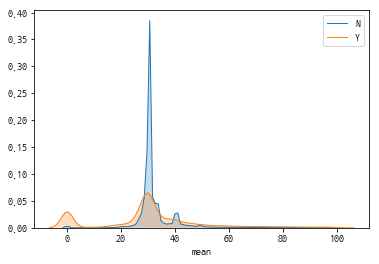

In [23]:
# pandas일 필요는 없음
#https://stackoverflow.com/questions/44482095/dataframe-filtering-rows-by-column-values
# tmp1['cycle'][(tmp1['is_churn'] == 0) & (tmp1['cycle'] < 800)] => Series
tmp = data[['is_churn', 'transaction_cycle_delta_mean']].rename(columns = {'transaction_cycle_delta_mean': 'mean'})
sns.distplot(tmp['mean'][(tmp['is_churn'] == 0) & (tmp['mean'] < 100)]
           , hist = False, kde = True
           , kde_kws = {'shade': True, 'linewidth': 1}, label = 'N')
sns.distplot(tmp['mean'][(tmp['is_churn'] == 1) & (tmp['mean'] < 100)]
           , hist = False, kde = True
           , kde_kws = {'shade': True, 'linewidth': 1}, label = 'Y')

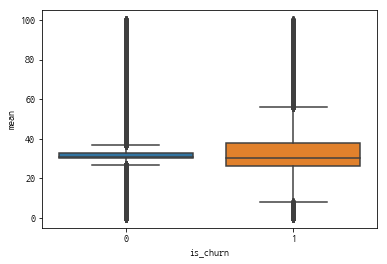

In [24]:
sns.boxplot( x = tmp[tmp['mean'] < 100]['is_churn']
           , y = tmp[tmp['mean'] < 100]['mean']
           )

## Transaction의 standard deviation

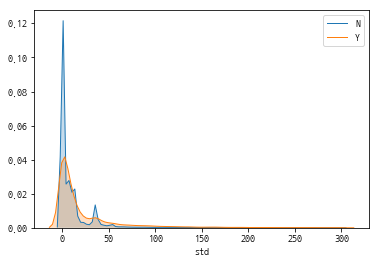

In [25]:

# pandas일 필요는 없음
#https://stackoverflow.com/questions/44482095/dataframe-filtering-rows-by-column-values
# tmp1['cycle'][(tmp1['is_churn'] == 0) & (tmp1['cycle'] < 800)] => Series
tmp = data[['is_churn', 'transaction_cycle_delta_std']].rename(columns = {'transaction_cycle_delta_std': 'std'})
sns.distplot(tmp['std'][(tmp['is_churn'] == 0) & (tmp['std'] < 300)]
           , hist = False, kde = True
           , kde_kws = {'shade': True, 'linewidth': 1}, label = 'N')
sns.distplot(tmp['std'][(tmp['is_churn'] == 1) & (tmp['std'] < 300)]
           , hist = False, kde = True
           , kde_kws = {'shade': True, 'linewidth': 1}, label = 'Y')

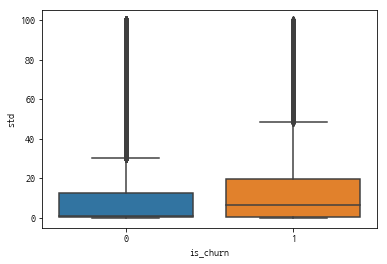

In [26]:
sns.boxplot( x = tmp[tmp['std'] < 100]['is_churn']
           , y = tmp[tmp['std'] < 100]['std'])

## Transaction Cycle
* Cycle 주기가 긴 비갱신 고객의 비율이 높음
* Cycle이 불규칙한 비갱신 고객의 비율이 높음

## **Other continuous variables**

In [27]:
# https://stackoverflow.com/questions/41329789/populating-seaborn-subplots-using-an-array
def boxplot(_vars, trunc = 0.9, n_col = 2, fig_size = (10, 10)):
    num_plots = len(_vars)
    fig, axes = plt.subplots(num_plots // n_col, n_col,figsize=fig_size)
    
    # iterate through all axes and create a violin plot
    for i, v in enumerate(_vars):
        row = i // n_col
        col = i % n_col
        ax_curr = axes[row, col]
        _max = np.max(data[v])
        _data = data[['is_churn', v]][data[v] < _max]
        sns.violinplot(x = _data['is_churn'], y = _data[v], data=data, ax=ax_curr)
        ax_curr.set_title(v)
    

In [28]:
vars = ['payment_method_id_entropy'
      , 'actual_amount_paid_entropy'
      , 'plan_list_price_entropy'
      , 'total_secs_sum'
      , 'actual_amount_paid_mean'
      , 'actual_amount_paid_nunique'
      , 'transaction_cycle_delta_min'
      , 'transaction_cycle_delta_max']

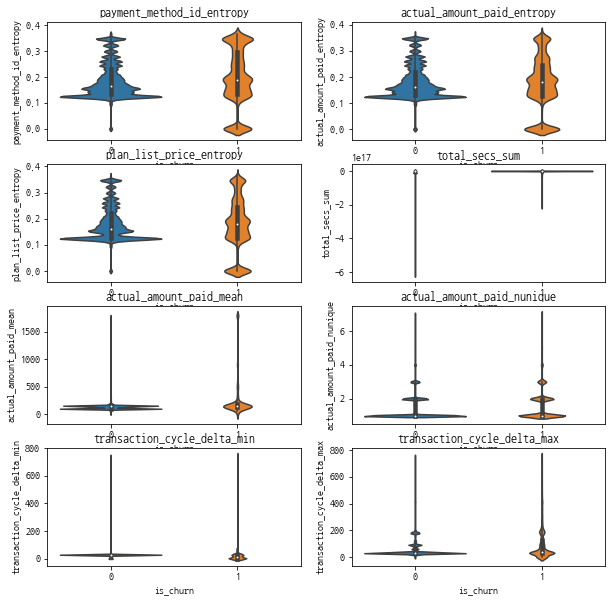

In [29]:
boxplot(vars)

## ** Time series properties**

In [30]:
data.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,date_count,num_25_sum,num_50_sum,...,transaction_date_last,transaction_date_nunique,membership_expire_date_first,membership_expire_date_last,membership_expire_date_nunique,is_cancel_nunique,transaction_cycle_delta_mean,transaction_cycle_delta_std,transaction_cycle_delta_min,transaction_cycle_delta_max
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18.0,36.0,female,9.0,20050406.0,26.0,51.0,16.0,...,2017-01-07,2,20161107,20170206,2,1,68.000000,0.000000,68.0,68.0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10.0,38.0,male,9.0,20050407.0,521.0,447.0,157.0,...,2017-02-24,23,20150321,20170321,22,2,34.318182,15.875667,16.0,95.0
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11.0,27.0,female,9.0,20051016.0,237.0,1570.0,950.0,...,2017-01-12,10,20160303,20170203,9,2,38.333333,30.512293,12.0,118.0
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13.0,23.0,female,9.0,20051102.0,721.0,7137.0,2386.0,...,2016-01-06,2,20160107,20170220,2,1,2.000000,0.000000,2.0,2.0
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3.0,27.0,male,9.0,20051228.0,758.0,1389.0,714.0,...,2017-01-28,8,20160216,20170227,8,1,108.142857,151.258530,3.0,409.0


In [31]:
import datetime as dt

data.registration_init_time = pd.to_datetime(data.registration_init_time, format='%Y%m%d')
data.membership_expire_date_last = pd.to_datetime(data.membership_expire_date_last, format='%Y%m%d')

data['subscription_period'] = data.membership_expire_date_last - data.registration_init_time
data['subscription_period_int'] = data['subscription_period']\
                                 .astype(dt.timedelta)\
                                 .map(\
                                      lambda x: np.nan if pd.isnull(x) else int(x.days)
                                  )

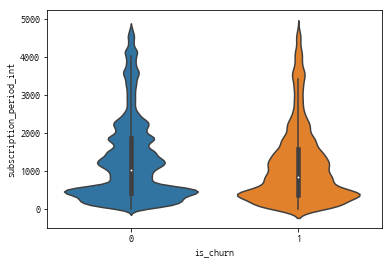

In [32]:
sns.violinplot(x = data[data['subscription_period_int'] > 0]['is_churn'] 
             , y = data[data['subscription_period_int'] > 0]['subscription_period_int'] 
             , data = data)

In [37]:
transaction_summary.head()

,index,msno,plan_list_price_count,plan_list_price_nunique,plan_list_price_entropy,payment_method_id_nunique,payment_method_id_entropy,actual_amount_paid_mean,actual_amount_paid_count,actual_amount_paid_nunique,...,transaction_date_last,transaction_date_nunique,membership_expire_date_first,membership_expire_date_last,membership_expire_date_nunique,is_cancel_nunique,transaction_cycle_delta_mean,transaction_cycle_delta_std,transaction_cycle_delta_min,transaction_cycle_delta_max
0,0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,1,1,0.000000,1,0.000000,0.0,1,1,...,2016-09-09,1,20160914,20160914,1,1,0.000000,0.000000,0.0,0.0
1,1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,1,1,0.000000,1,0.000000,1788.0,1,1,...,2015-11-21,1,20170104,20170104,1,1,0.000000,0.000000,0.0,0.0
2,2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,4,1,0.346574,1,0.346574,99.0,4,1,...,2017-02-15,4,20161215,20170315,4,1,30.333333,1.154701,29.0,31.0
3,3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,19,2,0.152125,1,0.154970,149.0,19,1,...,2017-01-31,19,20150319,20170319,19,1,40.611111,35.972439,28.0,182.0
4,4,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,26,2,0.123803,1,0.125311,149.0,26,1,...,2017-02-26,26,20150226,20170326,26,1,30.480000,0.770281,28.0,31.0


In [ ]:
tmp = transaction_summary[['msno', 'payment_method_id', 'plan_list_price']].groupby(['msno', 'payment_method_id']).count()
tmp.rename(columns = {'plan_list_price': 'count'}).reset_index().head(10)

*  고객이 여러가지 payment method id가 존재할 수 있음
* payment method id의 개수가 그룹별로 어떻게 다른지 궁금해짐

## Statistical test
* payment_method_id의 개수에 따라 churn 확률이 다른지 확인

In [38]:
# https://stackoverflow.com/questions/13404468/t-test-in-pandas
# Large sample problem으로 300개만 뽑아서 사용
from scipy.stats import ttest_ind
ttest_ind(pd.DataFrame(data[data['is_churn'] == 1]['payment_method_id_nunique']).sample(300)
        , pd.DataFrame(data[data['is_churn'] == 0]['payment_method_id_nunique']).sample(300)
         )

Ttest_indResult(statistic=array([4.23502357]), pvalue=array([2.6454147e-05]))

* 아주 유의미한 차이를 보임

#### 추가적으로 is_auto_renew, actual_amount_paid, 등의 분석이 필요